In [1]:
import scvelo as scv
import scanpy as sc
import os 
from pathlib import Path
import numpy as np 
import pandas as pd 
from anndata import AnnData


In [2]:
notebook_dir = os.getcwd()
notebook_dir

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\notebooks\\simulations\\data_simulation'

In [3]:
Path(notebook_dir).parents[3]

WindowsPath('c:/Users/OmerCagatayTalikaci/Desktop/github')

In [4]:
os.chdir(Path(notebook_dir).parents[3])

In [5]:
os.getcwd()

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github'

In [6]:
# function returns the analytical solution value for given tau, u0, alpha, beta for unspliced mRNA.
def unspliced(tau, u0, alpha, beta):
    """TODO."""
    expu = np.exp(-beta * tau)
    return (u0 * expu) + ((alpha / beta) * (1 - expu))

In [7]:
def spliced_nucleus(tau, sn0, alpha, nu, beta, u0):
    term1 = sn0 * np.exp(-nu * tau)
    term2 = (alpha / nu) * (1 - np.exp(-nu * tau))
    term3 =( (alpha - beta * u0) / (nu - beta) )* (np.exp(-nu * tau) - np.exp(-beta * tau))
    
    return term1 + term2 + term3

In [8]:
def spliced_cyto(tau, alpha, beta, gamma, nu, u0, sn0, sc0):
    
    exp_beta = np.exp(-beta * tau)
    exp_gamma = np.exp(-gamma * tau)
    exp_nu = np.exp(-nu * tau)
    
    term1 = (alpha / beta) * (1 - exp_beta) + (u0 * exp_beta)
    term1 *= (nu * beta) / ((nu - beta) * (gamma - beta))
    
    term2 = (alpha / nu) * (1 - exp_nu) + (u0 * exp_nu)
    term2 *= (nu * beta) / ((gamma - nu) * (nu - beta))
    
    term3 = (alpha / gamma) * (1 - exp_gamma) + (u0 * exp_gamma)
    term3 *= (nu * beta) / ((gamma - nu) * (gamma - beta))
    
    term4 = (nu / (gamma - nu)) * (exp_nu - exp_gamma) * sn0
    term5 = exp_gamma * sc0
    
    result = term1 - term2 + term3 + term4 + term5
    
    return result


# Vectorize Function 

In [9]:
import warnings
def vectorize(t, t_, alpha, beta, nu, gamma=None, alpha_=0, u0=0, sn0=0, sc0=0, sorted=False):
    
    """
    Vectorizes the parameters for mRNA splicing kinetics simulation based on the given time points.

    This function computes the vectorized values of the parameters `tau`, `alpha`, `u0`, and `s0`
    for a set of time points `t` and a threshold time `t_`.

    Parameters
    ----------
    t : array_like
        Array of time points at which to compute the parameters.
    t_ : float
        Threshold time point which separates two different regimes in the simulation.
    alpha : array_like or float
        Transcription rate parameter. This can be a scalar or an array of the same length as `t`.
    beta : array_like or float
        Splicing rate parameter. This can be a scalar or an array of the same length as `t`.
    gamma : array_like or float, optional
        Degradation rate parameter. Defaults to `beta / 2` if not provided.
    alpha_ : float, optional
        Secondary transcription rate parameter used after the threshold time `t_`. Defaults to 0.
    u0 : float, optional
        Initial unspliced mRNA level. Defaults to 0.
    s0 : float, optional
        Initial spliced mRNA level. Defaults to 0.
    sorted : bool, optional
        If True, the resulting arrays are sorted by time `t`. Defaults to False.

    Returns

    tuple of numpy.ndarray
        Tuple containing the following elements:
        - `tau` : numpy.ndarray
            Vectorized time points after applying the threshold `t_`.
        - `alpha` : numpy.ndarray
            Vectorized transcription rate parameter.
        - `u0` : numpy.ndarray
            Vectorized initial unspliced mRNA levels.
        - `s0` : numpy.ndarray
            Vectorized initial spliced mRNA levels.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        o = np.array(t < t_, dtype=int)
    tau = t * o + (t - t_) * (1 - o)

    u0_ = unspliced(t_, u0, alpha, beta)

    sn0_ = spliced_nucleus(t_, sn0, alpha, nu, beta, u0)

    sc0_ = spliced_cyto(t_, alpha, beta, gamma, nu, u0, sn0, sc0)


    # vectorize u0, s0 and alpha
    u0 = u0 * o + u0_ * (1 - o)
    sn0 = sn0 * o + sn0_ * (1 - o)
    sc0 = sc0 * o + sc0_ * (1 - o)
    alpha = alpha * o + alpha_ * (1 - o)

    if sorted:
        idx = np.argsort(t)
        tau, alpha, u0, s0 = tau[idx], alpha[idx], u0[idx], s0[idx]
    return tau, alpha, u0, sn0, sc0

# Simulate 

In [10]:
def switch_times(t_max, n_vars):
        # Define the lower and upper bounds for the uniform distribution
        lower_bound = 0.1 * t_max
        upper_bound = 0.5 * t_max
    
        # Generate uniformly distributed values between the bounds
        uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)
    
        return uniform_array


In [11]:
s = switch_times(20,200)

In [13]:
def draw_poisson(n):
    from random import seed, uniform  # draw from poisson
    t = np.cumsum([-0.1 * np.log(uniform(0, 1)) for _ in range(n - 1)])
    return np.insert(t, 0, 0) 

In [14]:
t = draw_poisson(600)

In [17]:
t *= 20 / np.max(t)

In [133]:
def cycle(array, n_vars=None):
    if isinstance(array, (np.ndarray, list, tuple)):
        return (
            array if n_vars is None else array * int(np.ceil(n_vars / len(array)))
        )
    else:
        return [array] if n_vars is None else [array] * n_vars


In [19]:
def switch_times(t_max, n_vars):
    lower_bound = 0.1 * t_max
    upper_bound = 0.5 * t_max

    uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)

    return uniform_array

In [20]:
s= switch_times(20,200)

In [24]:
s[:5]

array([6.80954244, 7.10825636, 6.24985664, 7.00108078, 8.24131227])

In [27]:
t_ = np.array([np.max(t[t < t_i * 20]) for t_i in s/20])

In [7]:
def simulation_3ode(
    n_obs=300,
    n_vars=None,
    alpha=None,
    beta=None,
    nu = None,
    gamma=None,
    alpha_=None,
    t_max=None,
    noise_model="normal",
    noise_level=1,
    switches=None,
    random_seed=0,
):
    """Simulation of mRNA splicing kinetics.

    Simulated mRNA metabolism with transcription, splicing and degradation.
    The parameters for each reaction are randomly sampled from a log-normal distribution
    and time events follow the Poisson law. The total time spent in a transcriptional
    state is varied between two and ten hours.

    .. image:: https://user-images.githubusercontent.com/31883718/79432471-16c0a000-7fcc-11ea-8d62-6971bcf4181a.png
       :width: 600px

    Returns
    -------
    Returns `adata` object
    """
    import numpy as np
    np.random.seed(random_seed)

    def draw_poisson(n):
        from random import seed, uniform  # draw from poisson

        seed(random_seed)
        t = np.cumsum([-0.1 * np.log(uniform(0, 1)) for _ in range(n - 1)])
        return np.insert(t, 0, 0)  # prepend t0=0

    def simulate_dynamics(tau, alpha, beta, nu, gamma, u0, sn0, sc0, noise_model, noise_level):
        ut = unspliced(tau, u0, alpha, beta)
        snt = spliced_nucleus(tau, sn0, alpha, nu, beta, u0)
        sct = spliced_cyto(tau, alpha, beta, gamma, nu, u0, sn0, sc0)

        if noise_model == "normal":  # add noise
            ut += np.random.normal(
                scale=noise_level * np.percentile(ut, 99) / 10, size=len(ut)
            )
            snt += np.random.normal(
                scale=noise_level * np.percentile(snt, 99) / 10, size=len(snt)
            )

            percentile_99 = np.percentile(sct, 99)
            print(sct)
            if percentile_99 < 0:
                a= alpha
                b= beta
                ta= tau
                

                raise ValueError("The 99th percentile of 'sct' is negative, leading to a negative scale.")
                return(sct)
            
            sct += np.random.normal(
                scale=noise_level * np.percentile(sct, 99) / 10, size=len(sct)
            )
        ut, snt, sct = np.clip(ut, 0, None), np.clip(snt, 0, None), np.clip(sct, 0, None)
        return ut, snt, sct

    #(4,0.6,0.3,0.25)
    alpha = 5 if alpha is None else alpha
    beta = 0.6 if beta is None else beta
    nu = 0.3 if nu is None else nu
    gamma = 0.25 if gamma is None else gamma
    alpha_ = 0 if alpha_ is None else alpha_

    t = draw_poisson(n_obs)
    if t_max is not None:
        t *= t_max / np.max(t)
    t_max = np.max(t)

    def cycle(array, n_vars=None):
        if isinstance(array, (np.ndarray, list, tuple)):
            return (
                array if n_vars is None else array * int(np.ceil(n_vars / len(array)))
            )
        else:
            return [array] if n_vars is None else [array] * n_vars
    
    import numpy as np

    def switch_times(t_max, n_vars):
        lower_bound = 0.1 * t_max
        upper_bound = 0.5 * t_max
    
        
        uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)
    
        return uniform_array


    # switching time point obtained as fraction of t_max rounded down

    # switches = (
    #     # cycle([0.4, 0.7, 1, 0.1], n_vars)
    #     cycle([4, 5, 6, 8], n_vars)
    #     if switches is None
    #     else cycle(switches, n_vars)
    # )
    switches = switch_times(t_max=t_max,n_vars=n_vars)

    t_ = np.array([np.max(t[t < t_i * t_max]) for t_i in switches])

    noise_level = cycle(noise_level, len(switches) if n_vars is None else n_vars)

    n_vars = min(len(switches), len(noise_level)) if n_vars is None else n_vars
    U = np.zeros(shape=(len(t), n_vars))
    Sn = np.zeros(shape=(len(t), n_vars))
    Sc = np.zeros(shape=(len(t), n_vars))

    def is_list(x):
        return isinstance(x, (tuple, list, np.ndarray))

    for i in range(n_vars):
        alpha_i = alpha[i] if is_list(alpha) and len(alpha) != n_obs else alpha
        beta_i = beta[i] if is_list(beta) and len(beta) != n_obs else beta
        nu_i = nu[i] if is_list(nu) and len(nu) != n_obs else nu
        gamma_i = gamma[i] if is_list(gamma) and len(gamma) != n_obs else gamma
        tau, alpha_vec, u0_vec, sn0_vec, sc0_vec = vectorize(
            t, t_[i], alpha_i, beta_i,nu_i, gamma_i, alpha_=alpha_, u0=0, sn0=0,sc0=0
        )

        print(f"i:{i}")

        U[:, i], Sn[:, i], Sc[:, i] = simulate_dynamics(
            tau,
            alpha_vec,
            beta_i,
            nu_i,
            gamma_i,
            u0_vec,
            sn0_vec,
            sc0_vec,
            noise_model,
            noise_level[i],
        )

    if is_list(alpha) and len(alpha) == n_obs:
        alpha = np.nan
    if is_list(beta) and len(beta) == n_obs:
        beta = np.nan
    if is_list(nu) and len(nu) == n_obs:
        nu = np.nan
    if is_list(gamma) and len(gamma) == n_obs:
        gamma = np.nan

    obs = {"true_t": t.round(2)}
    var = {
        "true_t_": t_[:n_vars],
        "true_alpha": np.ones(n_vars) * alpha,
        "true_beta": np.ones(n_vars) * beta,
        "true_nu": np.ones(n_vars) * nu,
        "true_gamma": np.ones(n_vars) * gamma,
        "true_scaling": np.ones(n_vars),
    }
    layers = {"unspliced": U,"spliced":Sn+Sc, "spliced_nuc": Sn, "spliced_cyto": Sc, "nucleic": U+Sn}

    return AnnData(Sn, obs, var, layers=layers)

In [ ]:
def draw_poisson(n):
        from random import seed, uniform  # draw from poisson

        seed(random_seed)
        t = np.cumsum([-0.1 * np.log(uniform(0, 1)) for _ in range(n - 1)])
        return np.insert(t, 0, 0)  # prepend t0=0

In [ ]:
t = draw_poisson(600)

In [ ]:
t

In [ ]:
def switch_times(t_max, n_vars):
    lower_bound = 0.1 * t_max
    upper_bound = 0.5 * t_max

    uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)

    return uniform_array

In [55]:
import numpy as np
import numpy as np

# Mean vector for the normal distribution
mu = np.array([2, 1, 0.6, 0.5])

# Correlation matrix (R)
R = np.array([[0.66, 0.38, 0.12, 0.032],
              [0.7, 0.16, 0.08, 0.003],
              [0.8, 0.08, 0.16, 0.03],
              [0.62, 0.032, 0.08, 0.16]])


# R = np.array([[2., 1., .2, .2],
#               [.2, .2, 1., .8],
#               [1., .2, .8, .6],
#               [1., 1., .8 ,.4]])

# Standard deviations (square root of the diagonal elements of R)
std_devs = np.sqrt(np.diag(R))

# Construct the covariance matrix from the correlation matrix
cov = np.outer(std_devs, std_devs) * R

# Generate 200 samples from the multivariate normal distribution
samples = np.random.multivariate_normal(mu, cov, size=200)

# Convert the normal samples to log-normal by exponentiating
log_normal_samples = np.exp(samples)

# Separate the parameters into individual arrays
alpha, nu, beta, gamma = log_normal_samples.T  # Transpose to unpack into four arrays






In [195]:
mu = np.array([2, 1.5, 0.5, 0.1])

R = np.array([[.16, .128, .08, .032],
              [.128, .16 , .08, .032],
              [.08, .08, .16 , .08],
              [.032 ,.032 , .08 , .16]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

cov = C* R
#cov = R
cov=np.log(cov)
alpha, beta , nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size=300).T)

In [8]:
alpha = np.abs(np.random.normal(8, scale=1, size=250))
beta = alpha - 2
nu = beta - 1
gamma = beta - 0.5 


In [15]:
alpha= list(alpha) 
nu  = list(nu)
beta = list(beta)
gamma = list(gamma)

In [226]:
import numpy as np

# Parameters for the normal distribution
mean = 0          # Mean of the normal distribution
std_dev = 1       # Standard deviation of the normal distribution
num_samples = 200  # Number of random values to generate for each list

# Generate four separate lists of positive random values from a normal distribution
lists_of_positive_values = [
    np.abs(np.random.normal(loc=mean, scale=std_dev, size=num_samples))
    for _ in range(4)
]


In [51]:
import numpy as np

In [ ]:
AnnData(S)

In [13]:
def switch_times(t_max, n_vars):
    lower_bound = 0.05 * t_max
    upper_bound = 0.8 * t_max

    
    uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)

    return uniform_array

In [14]:
s = switch_times(20,300)

In [20]:
adata = simulation_3ode(n_obs=600,t_max=20,n_vars=300,switches=s/20)

[[0.         0.1564535  0.06910561 ... 0.         0.         1.26724989]
 [0.5929656  0.         0.95959213 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.8755084  0.        ]
 ...
 [0.12113188 0.07073479 0.57989373 ... 0.         0.         1.50243583]
 [0.         0.         0.06801126 ... 0.         3.89786273 0.        ]
 [1.78837879 0.18167969 1.16753037 ... 0.         4.62527155 1.04717032]]


In [16]:
adata

AnnData object with n_obs × n_vars = 600 × 300
    obs: 'true_t'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'

In [13]:
import numpy as np

In [210]:
adata = scv.datasets.simulation(n_obs=600,t_max=20, n_vars=200)

In [201]:
adata = scv.datasets.simulation(n_obs=800,alpha=alpha,beta=beta,gamma=gamma,t_max=20,switches=s/20, n_vars=300)

In [226]:
adata.var

,true_t_,true_alpha,true_beta,true_nu,true_gamma,true_scaling,n_cells
0,2.037712,1.986205,0.913912,2.312691,5.913475,1.0,533
1,3.281254,14.352041,19.595564,5.787095,4.270037,1.0,483
2,15.517592,0.384659,0.344917,0.598932,0.350859,1.0,780
3,12.165593,8.987051,16.881849,2.151419,1.750226,1.0,676
4,14.566314,184.481835,94.278825,2.702010,0.999819,1.0,714
...,...,...,...,...,...,...,...
295,12.513097,6.944716,2.665581,5.781729,8.045860,1.0,697
296,5.975331,0.132156,0.032239,0.053607,0.031424,1.0,740
297,8.582472,6.306617,1.734552,0.343778,0.047353,1.0,723
298,6.004733,9.514889,3.926554,0.832762,1.815340,1.0,591


In [227]:
adata = simulation_3ode(n_obs=800, t_max=20 ,alpha=alpha,nu=nu,gamma=gamma,beta=beta,switches = s/20 , n_vars=300)

In [229]:
adata

AnnData object with n_obs × n_vars = 800 × 300
    obs: 'true_t'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'

In [230]:
adata.var

,true_t_,true_alpha,true_beta,true_nu,true_gamma,true_scaling
0,2.037712,1.986205,0.913912,2.312691,5.913475,1.0
1,3.281254,14.352041,19.595564,5.787095,4.270037,1.0
2,15.517592,0.384659,0.344917,0.598932,0.350859,1.0
3,12.165593,8.987051,16.881849,2.151419,1.750226,1.0
4,14.566314,184.481835,94.278825,2.702010,0.999819,1.0
...,...,...,...,...,...,...
295,12.513097,6.944716,2.665581,5.781729,8.045860,1.0
296,5.975331,0.132156,0.032239,0.053607,0.031424,1.0
297,8.582472,6.306617,1.734552,0.343778,0.047353,1.0
298,6.004733,9.514889,3.926554,0.832762,1.815340,1.0


In [236]:
adata.write("data/simulated/adata_simulated_3ode.h5ad")

# Preprocessing 

In [82]:
adata = a.copy()

In [237]:
sc.pp.filter_cells(adata,min_counts = 20)
sc.pp.filter_genes(adata,min_cells = 4)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [238]:
sc.pp.pca(adata)
sc.pp.neighbors(adata,n_neighbors = 23  ,n_pcs=0)
sc.tl.umap(adata, min_dist=1)
sc.tl.leiden(adata)

In [239]:
adata

AnnData object with n_obs × n_vars = 800 × 300
    obs: 'true_t', 'n_counts', 'leiden'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'
    obsp: 'distances', 'connectivities'

# Velocity with spliced-unspliced

In [240]:
adata_s_u = adata.copy()

In [241]:
scv.pp.moments(adata_s_u, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [242]:
scv.tl.recover_dynamics(adata_s_u,n_jobs=8)

recovering dynamics (using 8/24 cores)


  0%|          | 0/228 [00:00<?, ?gene/s]

    finished (0:00:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [243]:
scv.tl.velocity(adata_s_u, mode='dynamical')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [244]:
scv.tl.velocity_graph(adata_s_u)

computing velocity graph (using 1/24 cores)


  0%|          | 0/800 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


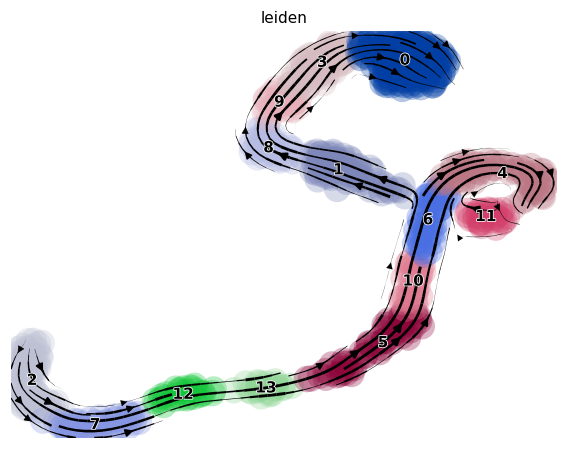

In [245]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.velocity_embedding_stream(adata_s_u, basis='umap',color="leiden", dpi=110)

# Velocity - nucleus -cyto

In [182]:
adata_n_c = adata.copy()

In [183]:
adata_n_c

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'
    obsp: 'distances', 'connectivities'

In [184]:
adata_n_c.layers["unspliced"]= adata_n_c.layers["nucleic"]
adata_n_c.layers["spliced"]= adata_n_c.layers["spliced_cyto"]

In [185]:
scv.pp.moments(adata_n_c, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [186]:
scv.tl.recover_dynamics(adata_n_c, n_jobs=8)

recovering dynamics (using 8/24 cores)


  0%|          | 0/180 [00:00<?, ?gene/s]

    finished (0:00:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [187]:
scv.tl.velocity(adata_n_c, mode='dynamical')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [188]:
scv.tl.velocity_graph(adata_n_c)

computing velocity graph (using 1/24 cores)


  0%|          | 0/600 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


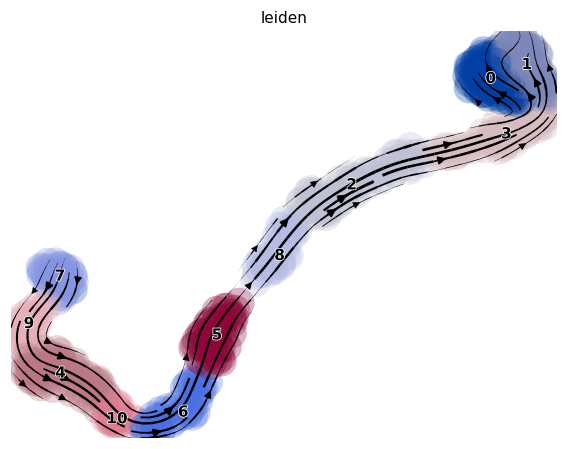

In [189]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.velocity_embedding_stream(adata_n_c, basis='umap',color="leiden", dpi=110)

# scv.tl.velocity()

In [183]:
adata_n_c.var.velocity_genes.value_counts()

velocity_genes
True     245
False      5
Name: count, dtype: int64

In [184]:
adata

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [185]:
gene_subset = ~np.isnan(adata.var["fit_alpha"].values)

In [194]:
vdata = adata[:, gene_subset]

In [193]:
np.count_nonzero(gene_subset==True)

250

# Simulate Space 

In [39]:
import random
def simulate_space(adata:'AnnData',how:str='random',size_x:str=1000,size_y:str=1000,spread:int=10):
    '''Simulate the spatial distribution of cells
    Parameters
    ----------
    adata:'AnnData object'
        Adata object including previously simulated cells 
    how:'str'
        Method to use to simulate the space.Options are:
            - 'random': assign a random position to each cell
            - 'spatial_gradient': cells are positioned forming a gradient in y according to their diff. trajectory, included in (y).
    size_x:'float':
        X dimension of the tissue space simulated 
    size_y:'float':
        Y dimension of the tissue space simulated
    spread:'int':
        If 'spatial_gradient' is considered as a method, spreads indicates how many units can the Y coordinate of a cell differ the Y position predicted from 'true_t'
        The higher this value is, the less clear the gradient will be
    Returns
    -------
    adata:'AnnData object'
        Adata object including previously simulated cells with spatial positions
    
    '''
    if how=='random':
        n_cells=adata.obs.shape[0]
        xpos=[random.uniform(0,size_x) for _ in range(n_cells)]
        ypos=[random.uniform(0,size_y) for _ in range(n_cells)]
    if how=='spatial_gradient':
        n_cells=adata.obs.shape[0]
        xpos=[random.uniform(0,size_x) for _ in range(n_cells)]
        n_cells=adata.obs.shape[0]
        relative_y=adata.obs['true_t'].div(adata.obs['true_t'].max())*size_y
        ypos=[i+random.uniform(-spread,spread) for i in relative_y]

    adata.obs['x']=xpos
    adata.obs['y']=ypos
    adata.obsm['spatial']=np.array([list(xpos),list(ypos)]).transpose()

    return adata

In [36]:
adata

AnnData object with n_obs × n_vars = 600 × 300
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition', 'x', 'y'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'spatial'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [40]:
size_x=600
size_y=600
n_genes=300
n_cells=600
cohabiting=False
a = simulate_space(adata,how='spatial_gradient',spread=15,size_x=size_x,size_y=size_y)

Renamed 'spatial' to convention 'X_spatial' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)


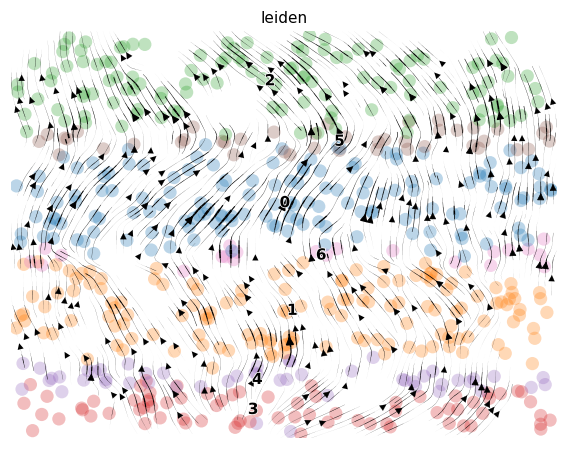

In [41]:
scv.pl.velocity_embedding_stream(a, basis='spatial',color="leiden", dpi=110,s=300,density=3)

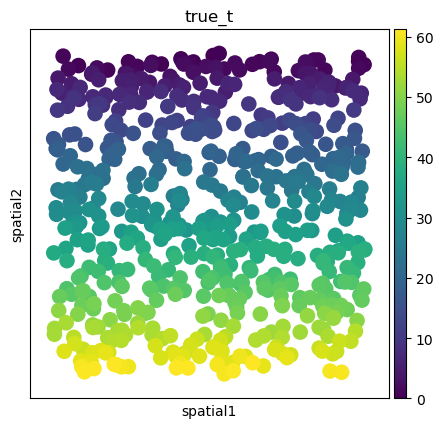

In [43]:
sc.pl.spatial(a,color='true_t',spot_size=30)

# Metrics - Between Models 

In [ ]:
# Code of separating adatas might be helpful for calculating metrics for different clusters . 
clusters = adata.obs['leiden'].unique().tolist()
alldata = {}
for cluster in clusters:
    alldata[cluster] = adata[adata.obs['batch_id'] == cluster,]

In [58]:
# While working on anndata object as a values of a dictionary, anndata_dict.copy() doesn't prevent changement in the original dict.
# Followed line does.
alldata_norm = {key: adata.copy() for key, adata in alldata.items()}

In [59]:
adatas = [adata_s_u,adata_n_c]
names = ['adata_s_u', 'adata_n_c']

adatas_copy = [a.copy for a in adatas]

In [40]:
alldata = {}
alldata['adata_n_c'] = adata_n_c
alldata['adata_s_u'] = adata_s_u

## MSE 

- compute_dynamics() function should be adapted for 3ode, (maybe not)

In [33]:
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from scvelo.plotting.simulation import compute_dynamics

In [31]:
adata_s_u

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [34]:
def get_fit_scvelo(adata):
    scvelo_fit_s = pd.DataFrame(
        np.zeros_like(adata.layers["Ms"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )
    scvelo_fit_u = pd.DataFrame(
        np.zeros_like(adata.layers["Mu"]),
        index=adata.obs_names,
        columns=adata.var_names,
    )

    for i, g in tqdm(enumerate(adata.var_names)):
        _, ut, st = compute_dynamics(
            adata,
            basis=adata.var_names[i],
            key="fit",
            extrapolate=False,
            sort=False,
            t=None,
        )
        scvelo_fit_s[g] = st
        scvelo_fit_u[g] = ut
    return scvelo_fit_s, scvelo_fit_u

In [35]:
# compute mse_1
def compute_mse(ms, mu, mn, mc, fit_s, fit_u, fit_n, fit_c):
    mse_s = np.mean((fit_s - ms) ** 2, axis=0)
    mse_u = np.mean((fit_u - mu) ** 2, axis=0)
    mse_n = np.mean((fit_n - mn) ** 2, axis=0)
    mse_c = np.mean((fit_c - mc) ** 2, axis=0)

    mse_df = pd.DataFrame()
    sn = np.log10(mse_s / mse_n)
    uc = np.log10(mse_u / mse_c)

    mse_df["log10 MSE ratio"] = np.concatenate([sn, uc]).ravel()
    mse_df["Feature"] = ["spl-nuc"] * len(sn) + ["uns-cyt"] * len(uc)
    return mse_df

In [36]:
fit_s, fit_u = get_fit_scvelo(adata_s_u)
fit_n, fit_c = get_fit_scvelo(adata_n_c)

ms = adata_s_u.to_df("Ms")
mu = adata_s_u.to_df("Mu")
mn = adata_n_c.to_df("Ms")
mc = adata_n_c.to_df("Mu")

mse_s = np.mean((fit_s - ms) ** 2, axis=0)
mse_u = np.mean((fit_u - mu) ** 2, axis=0)
mse_n = np.mean((fit_n - mn) ** 2, axis=0)
mse_c = np.mean((fit_c - mc) ** 2, axis=0)

mse_df = compute_mse(ms,mu,mn,mc,fit_s,fit_u,fit_n,fit_c)

250it [00:00, 983.10it/s] 
250it [00:00, 961.99it/s]


<Axes: xlabel='log10 MSE ratio'>

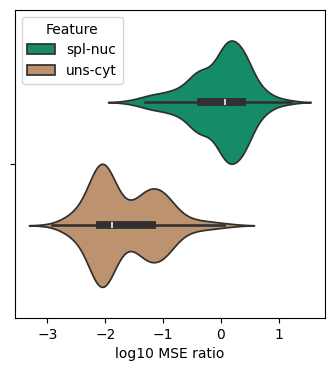

In [37]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(
        data=mse_df,
        orient="h",
        ax=ax,
        x="log10 MSE ratio",
        hue="Feature",
        palette=["#029e73", "#ca9161"],
    )

## mse gene

In [38]:
# compute mse 
def compute_mse_gene(adata):
    """
    s_n stands for moment of spliced or nucleic RNA abundance.
    u_c stands for moment of unspliced or cytoplasmic RNA abundance.
      """
    s_n = adata.to_df("Ms")
    u_c = adata.to_df("Mu")

    fit_s_n, fit_u_c = get_fit_scvelo(adata)

    mse_s_n = np.mean((fit_s_n - s_n) ** 2, axis=0)
    mse_u_c = np.mean((fit_u_c - u_c) ** 2, axis=0)  
    sum_mse = mse_s_n + mse_u_c    

    return mse_s_n, mse_u_c, sum_mse

In [41]:
mse_gene_df = pd.DataFrame(columns=['Dataset', 'mse_s_n', 'mse_u_c', 'sum_mse'])

for key, adata in alldata.items():
    mse_s_n, mse_u_c, sum_mse = compute_mse_gene(adata)
    
    temp_df = pd.DataFrame({
        'Dataset': [key] * len(mse_s_n),
        'mse_s_n': mse_s_n,
        'mse_u_c': mse_u_c,
        'sum_mse': sum_mse
    })
    

    mse_gene_df = pd.concat([mse_gene_df, temp_df], ignore_index=True)

250it [00:00, 659.03it/s] 
250it [00:00, 991.52it/s]


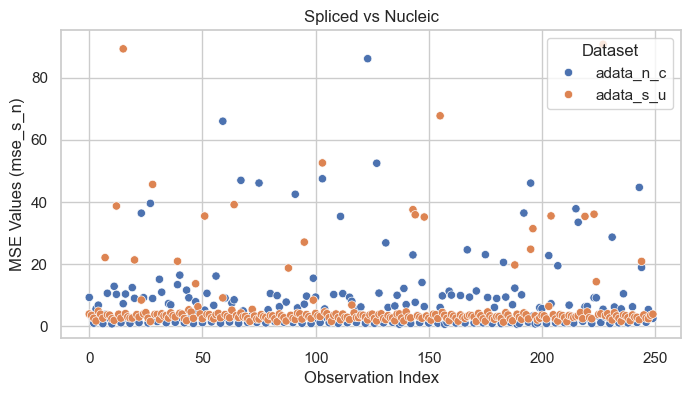

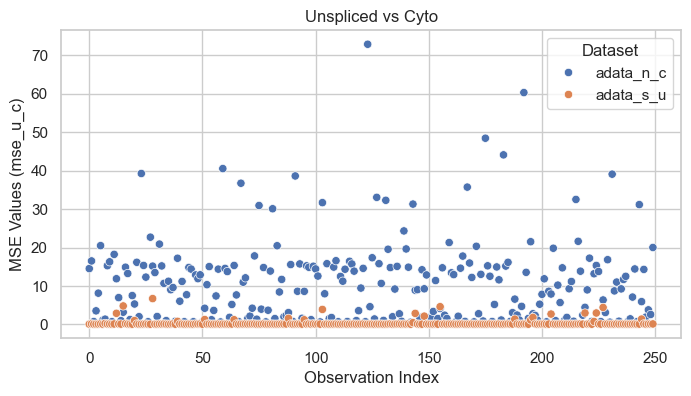

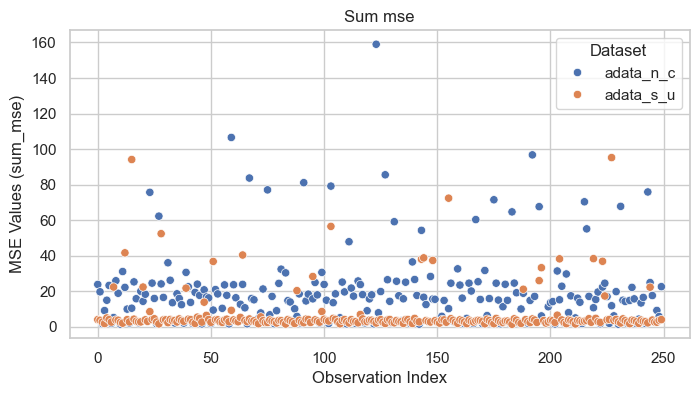

In [42]:


# Assuming your DataFrame is named 'mse_df'
# Create an observation index for each unique observation (0 to 599)
mse_gene_df['gene_index'] = mse_gene_df.groupby('Dataset').cumcount()

# Set the style of seaborn
sns.set(style='whitegrid')

# Initialize the plot for mse_s_n
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='gene_index', y='mse_s_n', hue='Dataset')
plt.xlabel('Observation Index')
plt.ylabel('MSE Values (mse_s_n)')
plt.title('Spliced vs Nucleic')
plt.legend(title='Dataset', loc='upper right')
plt.show()

# Initialize the plot for mse_u_c
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='gene_index', y='mse_u_c', hue='Dataset')
plt.xlabel('Observation Index')
plt.ylabel('MSE Values (mse_u_c)')
plt.title('Unspliced vs Cyto')
plt.legend(title='Dataset', loc='upper right')
plt.show()

# Initialize the plot for sum_mse
plt.figure(figsize=(8, 4))
sns.scatterplot(data=mse_gene_df, x='gene_index', y='sum_mse', hue='Dataset')
plt.xlabel('Observation Index')
plt.ylabel('MSE Values (sum_mse)')
plt.title('Sum mse')
plt.legend(title='Dataset', loc='upper right')
plt.show()


In [271]:
mse_gene_df[mse_gene_df["sum_mse"]<1.5]

,Dataset,mse_s_n,mse_u_c,sum_mse,gene_index
230,adata_n_c,0.904671,0.591997,1.496668,230
433,adata_s_u,1.362782,0.094589,1.457372,183


In [252]:
adata_n_c

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [253]:
scv.tl.latent_time(adata_n_c)

computing terminal states
    identified 2 regions of root cells and 4 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


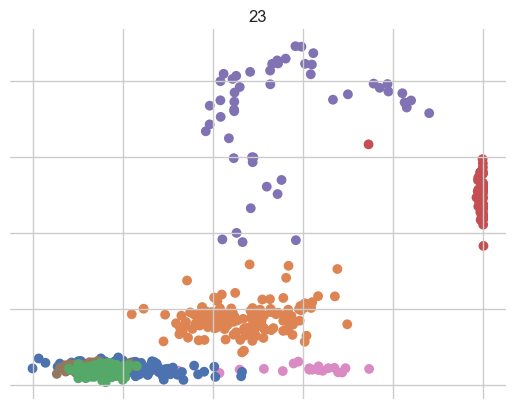

In [254]:
var_names = ['23']
#scv.pl.scatter(adata, var_names, frameon=False)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(adata_n_c, x='latent_time', y='23',color="leiden", frameon=False)

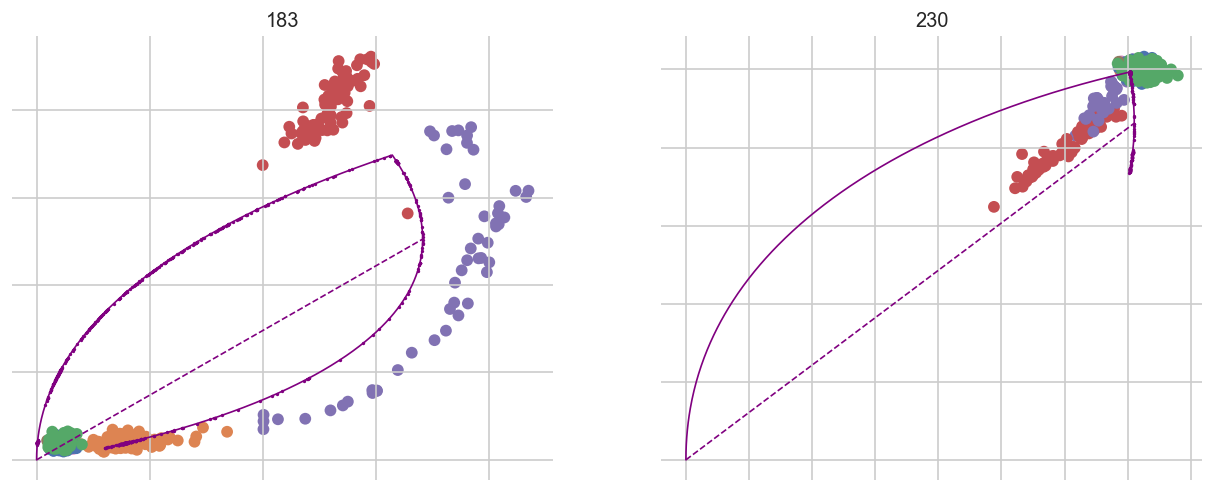

In [272]:
scv.pl.scatter(adata_n_c,color="leiden", basis=['183','230'], ncols=3, frameon=False,dpi=120)

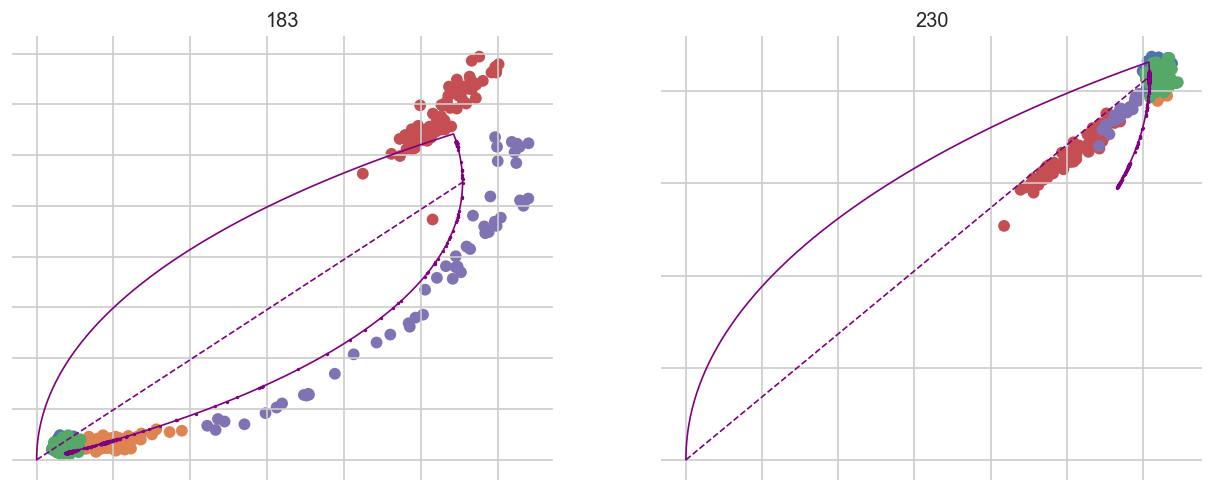

In [273]:
scv.pl.scatter(adata_s_u,color="leiden", basis=['183','230'], ncols=3, frameon=False,dpi=120)

## mse cell


In [153]:

def compute_mse_cell(adata):
    """
    s_n stands for moment of spliced or nucleic RNA abundance.
    u_c stands for moment of unspliced or cytoplasmic RNA abundance.
      """
    s_n = adata.to_df("Ms")
    u_c = adata.to_df("Mu")

    fit_s_n, fit_u_c = get_fit_scvelo(adata)

    mse_s_n = np.mean((fit_s_n - s_n) ** 2, axis=1)
    mse_u_c = np.mean((fit_u_c - u_c) ** 2, axis=1)  
    sum_mse = mse_s_n + mse_u_c    

    return mse_s_n, mse_u_c, sum_mse

In [209]:
mse_cell_df = pd.DataFrame(columns=['Dataset', 'mse_s_n', 'mse_u_c', 'sum_mse'])

for key, adata in alldata.items():
    mse_s_n, mse_u_c, sum_mse = compute_mse(adata)
    
    temp_df = pd.DataFrame({
        'Dataset': [key] * len(mse_s_n),
        'mse_s_n': mse_s_n,
        'mse_u_c': mse_u_c,
        'sum_mse': sum_mse
    })
    

    mse_cell_df = pd.concat([mse_cell_df, temp_df], ignore_index=True)

250it [00:00, 1736.71it/s]
250it [00:00, 1937.43it/s]


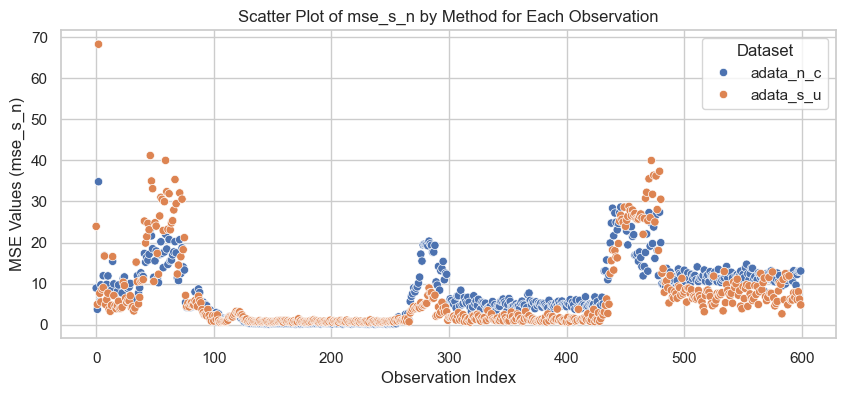

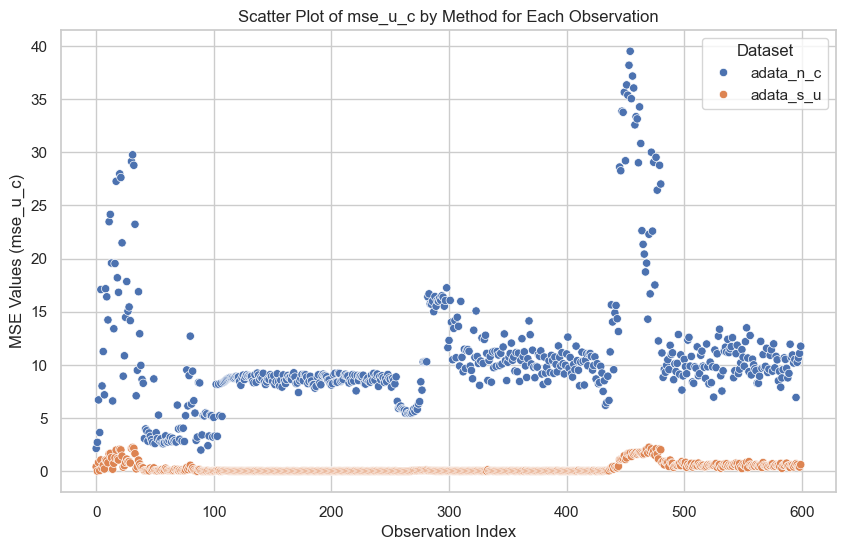

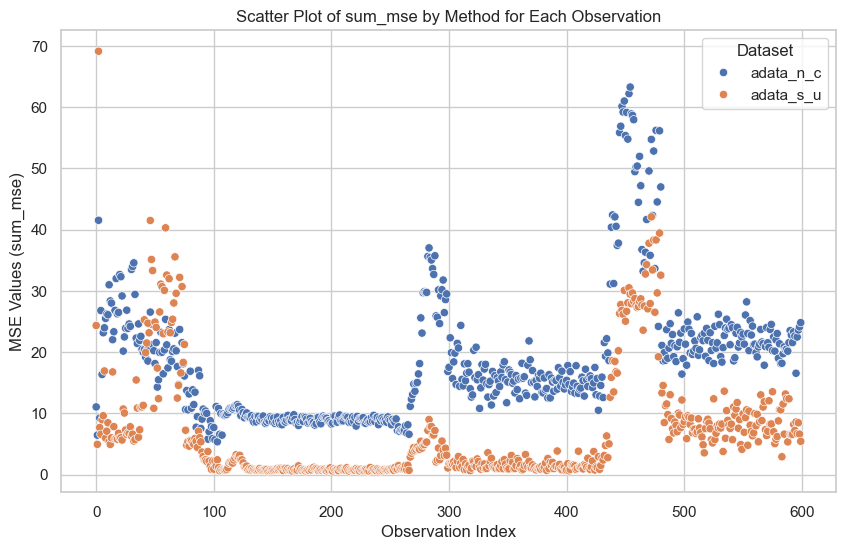

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'mse_df'
# Create an observation index for each unique observation (0 to 599)
mse_cell_df['cell_index'] = mse_cell_df.groupby('Dataset').cumcount()

# Set the style of seaborn
sns.set(style='whitegrid')

# Initialize the plot for mse_s_n
plt.figure(figsize=(10, 4))
sns.scatterplot(data=mse_cell_df, x='cell_index', y='mse_s_n', hue='Dataset')
plt.xlabel('Observation Index')
plt.ylabel('MSE Values (mse_s_n)')
plt.title('Scatter Plot of mse_s_n by Method for Each Observation')
plt.legend(title='Dataset', loc='upper right')
plt.show()

# Initialize the plot for mse_u_c
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mse_cell_df, x='cell_index', y='mse_u_c', hue='Dataset')
plt.xlabel('Observation Index')
plt.ylabel('MSE Values (mse_u_c)')
plt.title('Scatter Plot of mse_u_c by Method for Each Observation')
plt.legend(title='Dataset', loc='upper right')
plt.show()

# Initialize the plot for sum_mse
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mse_cell_df, x='cell_index', y='sum_mse', hue='Dataset')
plt.xlabel('Observation Index')
plt.ylabel('MSE Values (sum_mse)')
plt.title('Scatter Plot of sum_mse by Method for Each Observation')
plt.legend(title='Dataset', loc='upper right')
plt.show()


In [232]:
mse_cell_df[mse_cell_df['sum_mse']>50]

,Dataset,mse_s_n,mse_u_c,sum_mse,cell_index
445,adata_n_c,27.244685,28.616280,55.860965,445
446,adata_n_c,28.631375,28.268424,56.899800,446
447,adata_n_c,26.270537,33.870025,60.140562,447
448,adata_n_c,25.460834,33.761412,59.222246,448
449,adata_n_c,25.358719,35.653154,61.011873,449
450,adata_n_c,26.161660,29.209222,55.370882,450
451,adata_n_c,22.813737,36.341928,59.155666,451
452,adata_n_c,19.423127,35.373462,54.796588,452
453,adata_n_c,24.026798,38.191215,62.218013,453
454,adata_n_c,23.791450,39.506038,63.297488,454


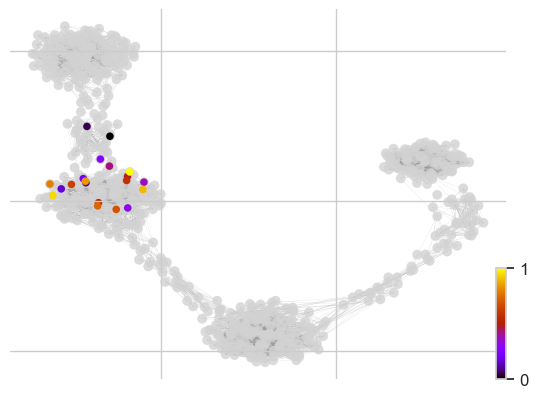

In [233]:
x, y = scv.utils.get_cell_transitions(adata_n_c, basis='umap', starting_cell=445)
ax = scv.pl.velocity_graph(adata_n_c, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

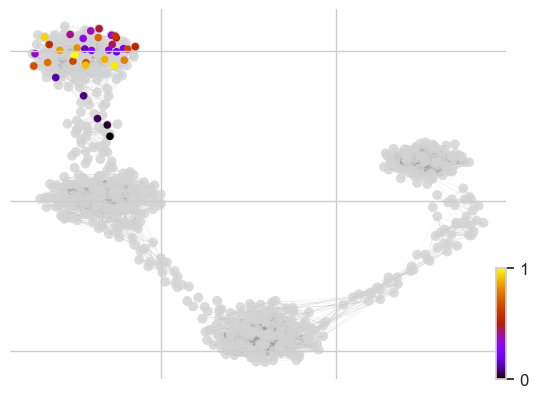

In [234]:
x, y = scv.utils.get_cell_transitions(adata_s_u, basis='umap', starting_cell=445)
ax = scv.pl.velocity_graph(adata_s_u, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

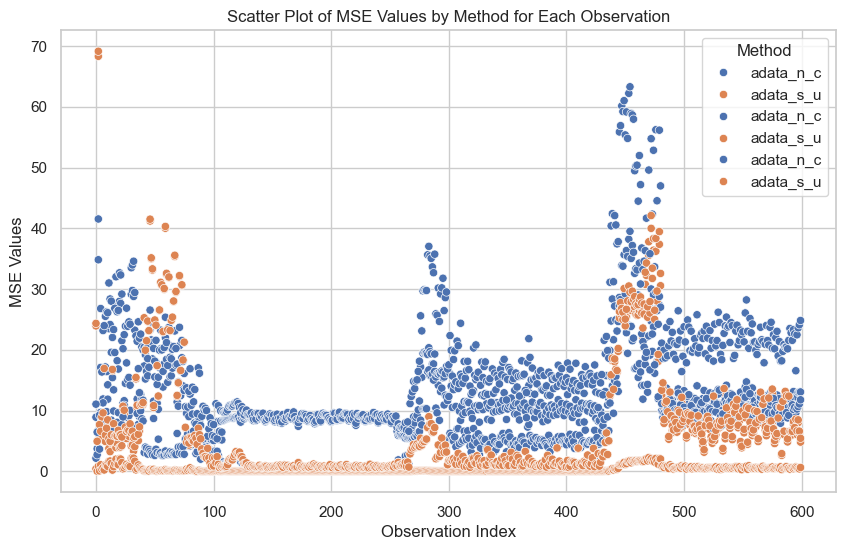

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'df'
# Create an observation index for each unique observation (0 to 599)
mse_df['cell_index'] = mse_df.groupby('Dataset').cumcount()

# Set the style of seaborn
sns.set(style='whitegrid')

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot scatter plots for each MSE column, colored by 'method'
sns.scatterplot(data=mse_df, x='cell_index',y='mse_s_n' , hue='Dataset')
sns.scatterplot(data=mse_df, x='cell_index',y='mse_u_c' , hue='Dataset')
sns.scatterplot(data=mse_df, x='cell_index',y='sum_mse' , hue='Dataset')

# Add labels and title
plt.xlabel('Observation Index')
plt.ylabel('MSE Values')
plt.title('Scatter Plot of MSE Values by Method for Each Observation')
plt.legend(title='Method', loc='upper right')
plt.show()


TypeError: seaborn.utils._scatter_legend_artist() got multiple values for keyword argument 'label'

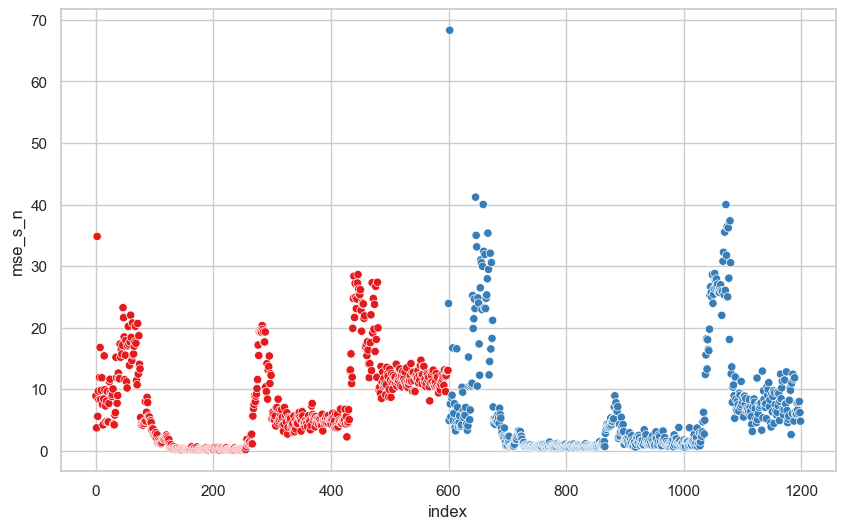

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'df'
# Create an index column for plotting against it
mse_df['index'] = mse_df.index

# Set the style of seaborn
sns.set(style='whitegrid')

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot scatter plots for each MSE column, colored by 'method'
sns.scatterplot(data=mse_df, x='index', y='mse_s_n', hue='Dataset', palette='Set1', label='mse_s_n', marker='o')
sns.scatterplot(data=mse_df, x='index', y='mse_u_c', hue='Dataset', palette='Set2', label='mse_u_c', marker='x')
sns.scatterplot(data=mse_df, x='index', y='sum_mse', hue='Dataset', palette='Set3', label='mse_sum', marker='v')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('MSE Values')
plt.title('Scatter Plot of MSE Values by Method')
plt.legend(title='Method', loc='upper right')
plt.show()


In [ ]:
mse_df.iloc[600:1200][mse_df.iloc[600:1200][]]

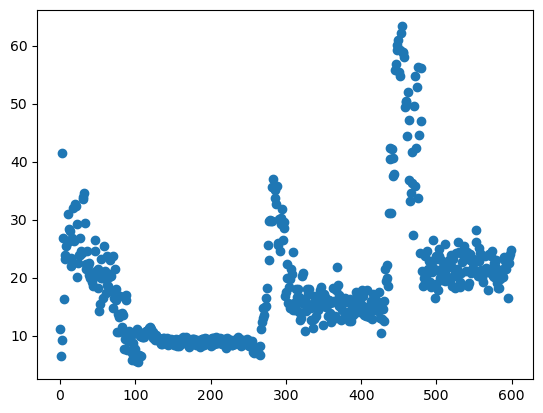

In [176]:
plt.scatter(mse_df.index[0:600], mse_df.iloc[0:600]["sum_mse"])

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# check the values by gene with mse values
# compare by cell 

<Axes: xlabel='sum_mse'>

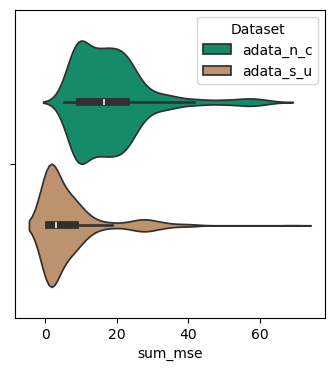

In [157]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(
        data=mse_df,
        orient="h",
        ax=ax,
        x="sum_mse",
        hue="Dataset",
        palette=["#029e73", "#ca9161"],
    )

## Confidence

In [203]:
adata

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [42]:
def compute_confidence(adata, vkey="velocity"):
    velo = adata.layers[vkey]
    # gc = gearys_c(adata, vals=velo.transpose())
    scv.tl.velocity_graph(adata, vkey=vkey, n_jobs=2)
    scv.tl.velocity_confidence(adata, vkey=vkey)
    g_df = pd.DataFrame()
    g_df["Velocity confidence"] = adata.obs[f"{vkey}_confidence"].to_numpy().ravel()
    return g_df

In [43]:
adatas = [adata_s_u,adata_n_c]
names = ["spl-uns", "nuc-cyt"]

df = []
for a, n in zip(adatas,names):
    conf = compute_confidence(a)
    conf["velo_type"] = n
    df.append(conf)
    
    

computing velocity graph (using 2/8 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 2/8 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [113]:
adata

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'
    obsp: 'distances', 'connectivities'

In [112]:
# compare the cells in pairs by sorting them by true_t 
df.groupby("velo_type").min()

,Velocity confidence
velo_type,
nuc-cyt,0.351024
spl-uns,0.276152


In [46]:
df = pd.concat(df,axis=0)

<Axes: xlabel='Velocity confidence'>

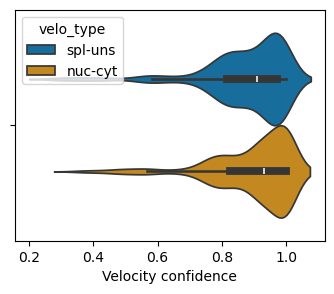

In [48]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.violinplot(
    data=df,
    ax=ax,
    orient="h",
    x="Velocity confidence",
    hue="velo_type",
    palette=sns.color_palette(['#0173B2', '#DE8F05']))

# Correlation

In [50]:
adata_s_u

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [51]:
adata_n_c

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

In [52]:
corr_mat = np.corrcoef(
    adata_s_u.to_df("velocity"), adata_n_c.to_df("velocity"), rowvar=False
)
cross_corrs = np.diagonal(corr_mat[a.shape[1] :, : a.shape[1]])


<Axes: >

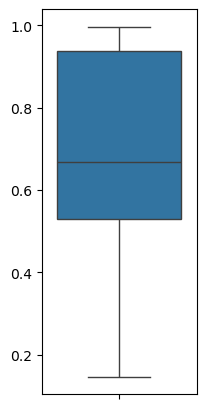

In [60]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.boxplot(cross_corrs, ax= ax)

# Time Correlations 

In [105]:
adata_s_u.var.velocity_genes

0      True
1      True
2      True
3      True
4      True
       ... 
245    True
246    True
247    True
248    True
249    True
Name: velocity_genes, Length: 250, dtype: bool

In [137]:
corr_mat = np.corrcoef(
    adata_s_u.to_df("fit_t"), adata_n_c.to_df("fit_t"), rowvar=False
)
cross_corrs = np.diagonal(corr_mat[adata_n_c.shape[1] :, : adata.shape[1]])


In [138]:
corr_mat.shape

(500, 500)

<Axes: >

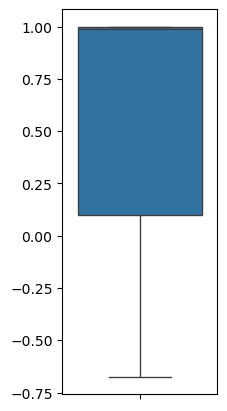

In [73]:
fig, ax = plt.subplots(figsize=(2, 5))
sns.boxplot(cross_corrs, ax= ax)

In [ ]:
#

# Metrics - inferred velocity and latent time 

In [74]:
from scipy.stats import pearsonr, spearmanr, ttest_ind

In [108]:
adata_s_u.layers['velocity'].shape

(600, 250)

In [104]:
adata

AnnData object with n_obs × n_vars = 600 × 250
    obs: 'true_t', 'n_counts', 'leiden'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'unspliced', 'spliced', 'spliced_nuc', 'spliced_cyto', 'nucleic'
    obsp: 'distances', 'connectivities'

In [76]:
adata_s_u.layers

Layers with keys: unspliced, spliced, spliced_nuc, spliced_cyto, nucleic, Ms, Mu, fit_t, fit_tau, fit_tau_, velocity, velocity_u

In [68]:
adata_s_u.layers["velocity_u"].shape

(600, 250)

In [80]:
adata_s_u.obs["true_t"]

0       0.00
1       0.02
2       0.04
3       0.13
4       0.27
       ...  
595    60.97
596    61.00
597    61.15
598    61.17
599    61.30
Name: true_t, Length: 600, dtype: float64

In [98]:
for var_id in range(len(adata_s_u.var_names)):
    x = adata_s_u.layers["velocity"][:, var_id]

In [101]:
adata_s_u.var_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '240', '241', '242', '243', '244', '245', '246', '247', '248', '249'],
      dtype='object', length=250)

In [ ]:
corr_df_velocity = pd.DataFrame(columns=["EM", "VI"], index=np.arange(len(adata.var_names)))

for var_id in range(len(adata.var_names)):
    x = adata_s_u.layers["velocity"][:, var_id]
    y = adata_s_u.layers["true_velocity"][:, var_id]
    corr_df_velocity.loc[var_id, "EM"] = pearsonr(x, y)[0]

    x = adata_n_c.layers["velocity"][:, var_id]
    y = adata_n_c.layers["true_velocity"][:, var_id]
    corr_df_velocity.loc[var_id, "VI"] = pearsonr(x, y)[0]

corr_df_velocity['model'] = adata.var['model'].values